### Setup

In [1]:
import math
import matplotlib.pyplot as plt
import torch
from torch.distributions.multivariate_normal import MultivariateNormal
from matplotlib.animation import FuncAnimation, PillowWriter

# Implementation of HMC

### Leap Frog Integrator

Leap Frog method is a method good to calculate the dynamics of particles. For Hamiltonian Monte Carlo, we want to consider the dynamics of a particle under a potential according to the probability density function. Therefore, this is a good choice of integrator to simulate the trajectories of the particles.

In the implementation of this method, automatic differentiation is used, so the all calculations are performed in torch.Tensor.

In [2]:
class LeapFrog():
    '''
    This is the class to implement the Leap Frog method. Attributes of this class contain information
    that is necessary for implementation of this method.

    simulate() method is to run the simulation of the particle and return the final state.

    animation() method is for generating the animation, it fixes several parameters for a better animation.
    '''

    def __init__(self, x0, p0, func_x, func_p, L, step_size):
        '''
        Parameters:
        -----------

        x0 : torch.Tensor
            The initial value of x
        p0 : torch.Tensor
            The initial value of p
        func_x : function
            This should be a function object, which should be the RHS of the dx/dt equation of the system
        func_p : function
            This should be a function object, which should be the RHS of the dp/dt equation of the system
        L : int
            The number of iterations to perform the simulation
        step_size : float
            The size of each step length in the simulation, in other words, this is the delta t
        '''
        self.func_x = func_x
        self.func_p = func_p
        self.x0 = x0
        self.p0 = p0
        self.step_size = step_size
        self.L = L

    def simulate(self):
        '''
        This method run the simulation and output the final state.

        Output:
        -------

        x : torch.Tensor
            The final state x of the simulation
        p : torch.Tensor
            The final state p of the simulation
        '''
        # Set up the tensors and enable auto grad
        x = self.x0.clone().detach().requires_grad_(True)
        p = self.p0.clone().detach().requires_grad_(True)

        # Calculate the corresponding y values and find grad
        y = self.func_p(x)
        acceleration = torch.autograd.grad(outputs=y, inputs=x)[0]

        if self.L > 0:
            sign = 1
        elif self.L < 0:
            sign = -1
        else:
            raise ValueError('You have to give a non-zero number of iterations')

        # Calculate the initial p_1/2, and simulate the first x
        p = p - sign * self.step_size * 0.5 * acceleration
        x = x + sign * self.step_size * self.func_x(p)

        # Do the rest simulations for 2:L
        L = sign * self.L
        for i in range(L - 1):
            y = self.func_p(x)
            acceleration = torch.autograd.grad(outputs=y, inputs=x)[0]
            p = p - sign * self.step_size * acceleration
            x = x + sign * self.step_size * self.func_x(p)

        # Calculate the final state of p, since we only calculated p_L-1/2
        y = self.func_p(x)
        acceleration = torch.autograd.grad(outputs=y, inputs=x)[0]
        p = p - sign * self.step_size * 0.5 * acceleration
        return x.clone().detach(), p.clone().detach()
    
    def animation(self):
        '''
        This method is to produce a different format of output, which is useful for a gif figure

        Output:
        -------

        x : torch.Tensor
            The final state x of the simulation
        p : torch.Tensor
            The final state p of the simulation
        intermediate_values_x : list of 1D-numpy.array
            The list contain the x value of intermediate points during the simulation
        '''
        # Set up the tensors and enable auto grad
        x = self.x0.clone().detach().requires_grad_(True)
        p = self.p0.clone().detach().requires_grad_(True)

        # Calculate the corresponding y values and find grad
        y = self.func_p(x)
        acceleration = torch.autograd.grad(outputs=y, inputs=x)[0]

        # Container for intermediate_points of x
        intermediate_values_x_all = []

        # Calculate the initial p_1/2, and simulate the first x
        p = p - self.step_size * 0.5 * acceleration
        x = x + self.step_size * self.func_p(p)
        intermediate_values_x_all.append(x.clone())

        # Do the rest simulations for 2:L
        for i in range(100 - 1):
            y = self.func_p(x)
            acceleration = torch.autograd.grad(outputs=y, inputs=x)[0]
            p = p - self.step_size * acceleration
            x = x + self.step_size * self.func_x(p)
            intermediate_values_x_all.append(x.clone())

        # Calculate the final state of p, since we only calculated p_L-1/2
        y = self.func_p(x)
        acceleration = torch.autograd.grad(outputs=y, inputs=x)[0]
        p = p - self.step_size * 0.5 * acceleration

        # Since the L might be very large, we only need a few points to plot, so only select some of these points
        intermediate_values_x = []
        for i in range(10):
            intermediate_values_x.append(intermediate_values_x_all[9 + i * 10].detach().numpy())
        return x, p, intermediate_values_x

### Implementation of HMC

For the implementation of HMC, there are two main steps:

1. Simulate the dynamics of the particle using the Leap Frog method.

2. Based on the result simulated in first step, whether or not to reject this new value based on the Hamiltonian of the system.

Then, repeat this process, we can get a good MCMC simulation.

The Hamiltonian is defined as $H(x, p) = U(x) + K(p)$, where $U(x)$ is the potential energy, $K(p)$ is the kinetic energy.

Here, $x$ can be interpreted as position, $p$ can be interpreted as momentum.

$U(x) = -ln(pdf(x))$, where $pdf(x)$ is the probability density function that want to sample from.

$K(p) = \frac{1}{2} p^T M ^ {-1} p$, where $M$ is the mass matrix, the covariance of initialisation covariance of momentum $p$.

The dynamical system that the Leap Frog to solve is:

$$\frac{dx}{dt} = \frac{\partial H(x, p)}{\partial p} = M ^ {-1} p$$

$$\frac{dp}{dt} = \frac{\partial H(x, p)}{\partial x} = -\frac{dU(x)}{dx}$$

In [3]:
class HMC():
    '''
    This is the class to implement the HMC. Attributes of this class contain information
    that is necessary for implementation of this method.

    simulate() method is to run the simulation of the particle and return the final state.

    animation() method is for generating the animation, it fixes several parameters for a better animation.
    '''
    def __init__(self, pdf, x0, epsilon, L, M, mass_matrix = None):
        '''
        Parameters:
        -----------

        pdf : function
            This should be a function object. This should be a function returning the value of pdf
            that you want to sample from at a specific point x.
        x0 : list or torch.Tensor
            The initial value of x
        epsilon : float
            The step length in the Leap Frog integrator
        L : int
            The number of iterations to perform the Leap Frog simulation
        mass_matrix : None or torch.Tensor
            The covariance matrix of initialisation of p in each iteration in HMC
        '''
        self.x0 = torch.tensor(x0)
        self.epsilon = epsilon
        self.L = L
        self.M = M

        # If the mass matrix is not provided, it will be identity by default
        if mass_matrix is None:
            self.mass_matrix = torch.eye(len(x0))

            # Define the Kinetic energy based on the mass matrix
            def func_x(p):
                return self._func_x(self.mass_matrix, p)
            self.func_x = func_x
            self.inverse_mass_matrix = torch.eye(len(x0))
        else:
            # If the matrix is provided, use the provided one
            self.mass_matrix = torch.tensor(mass_matrix)
            self.inverse_mass_matrix = torch.inverse(self.mass_matrix)

            # Define the Kinetic energy
            def func_x(p):
                return self._func_x(self.inverse_mass_matrix, p)
            self.func_x = func_x
        
        # Define the Potential energy based on the pdf
        def func_p(x):
            return self._func_p(pdf, x)
        self.func_p = func_p

    def simulate(self):
        '''
        Output:
        -------

        res : list of torch.Tensor
            A list containing all accepted sampling points
        '''
        res = []

        # Define the initial distribution of momentum p for each iteration of HMC
        mean = torch.zeros(len(self.x0))
        cov = self.mass_matrix.clone()
        mvn = torch.distributions.MultivariateNormal(mean, covariance_matrix=cov)

        # Define the initial value of x
        x = self.x0
        for i in range(self.M):
            p = mvn.sample()

            # Start the Leap Frog simulation
            leap_frog = LeapFrog(x, p, self.func_x, self.func_p, self.L, self.epsilon)
            x_new, p_new = leap_frog.simulate()
            p_new_t = p_new.reshape(1, -1)
            
            # Calculate the new and the old Hamoltonian
            H_new = self.func_p(x_new) + 0.5 * torch.matmul(p_new_t, torch.matmul(self.inverse_mass_matrix, p_new))
            H_old = self.func_p(x) + 0.5 * torch.matmul(p_new_t, torch.matmul(self.inverse_mass_matrix, p))

            # Define the acceptance/rejection threshold based on these Hamoltonians
            threshold = min(1, torch.exp(-1 * H_new) / torch.exp(-1 * H_old))
            random_number = torch.rand([]).item()
            if random_number > threshold:
                # If rejected, nothing happens
                pass
            else:
                # If accepted, use the new x values
                x = x_new.clone()
                res.append(x)
        return res
    
    def _func_x(self, inverse_mass_matrix, p):
        '''
        A private function for defining dx/dt
        '''
        return torch.matmul(inverse_mass_matrix, p)
    
    def _func_p(self, func, x):
        '''
        A private function for defining dp/dt
        '''
        return -1 * torch.log(func(x))
    
    def animation(self):
        '''
        Output:
        -------

        res_x : list of numpy.array
            A list containing states of x after each Leap Frog simulation
        res_p : list of numpy.array
            A list containing states of p after each Leap Frog simulation
        res_inter : list of numpy.array
            A list containing intermediate states of x during each Leap Frog simualtion, for animation purpose
        '''

        # Prepare the container for output
        res_x = []
        res_p = []
        res_inter = []

        # Define the initial distribution of momentum p for each iteration of HMC
        mean = torch.zeros(len(self.x0))
        cov = self.mass_matrix.clone()
        mvn = torch.distributions.MultivariateNormal(mean, covariance_matrix=cov)

        # Define the initial value of x
        x = self.x0
        for i in range(self.M):
            p = mvn.sample()
            res_x.append(x.clone().detach().numpy())
            res_p.append(p.clone().detach().numpy())

            # Start the Leap Frog simulation
            leap_frog = LeapFrog(x, p, self.func_x, self.func_p, self.L, self.epsilon)
            x_new, p_new, inter_x = leap_frog.animation()

            # Calculate the new and the old Hamoltonian
            p_new_t = p_new.reshape(1, -1)
            p_t = p.reshape(1, -1)
            H_new = self.func_p(x_new) + 0.5 * torch.matmul(p_new_t, torch.matmul(self.inverse_mass_matrix, p_new))
            H_old = self.func_p(x) + 0.5 * torch.matmul(p_t, torch.matmul(self.inverse_mass_matrix, p))

            # Define the acceptance/rejection threshold based on these Hamoltonians
            threshold = min(1, torch.exp(-1 * H_new) / torch.exp(-1 * H_old))
            random_number = torch.rand([]).item()
            if random_number > threshold:
                # If rejected, nothing happens
                pass
            else:
                # If accepted, use the new x values
                x = x_new.clone()

            # Append the output intermediate values to output
            res_inter.append(inter_x)
        return res_x, res_p, res_inter

### Test HMC simulation using an example distribution

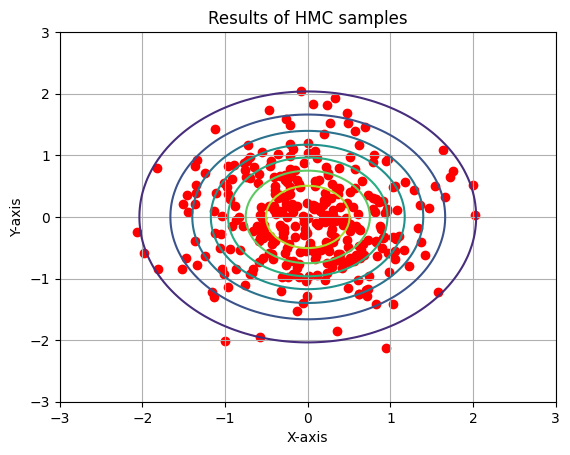

In [6]:
# Define the mean and covariance of the example distribution
mean = torch.tensor([0.0, 0.0])  # Example for a bivariate normal distribution
covariance = torch.tensor([[1.0, 0.0], [0.0, 1.0]])
mvn = MultivariateNormal(mean, covariance_matrix=covariance)

# Plot the contour of the pdf of example distribution
x, y = torch.meshgrid(torch.linspace(-3, 3, 100), torch.linspace(-3, 3, 100))
pos = torch.stack((x.flatten(), y.flatten()), dim=-1)
log_pdf_values = mvn.log_prob(pos).reshape(100, 100)
pdf_values = torch.exp(log_pdf_values).detach().numpy()
plt.contour(x, y, pdf_values)

# Prepare the pdf of the example distribution for HMC simulation
def multivariate_pdf(x):
    mean = torch.tensor([0.0, 0.0])
    covariance = torch.tensor([[1.0, 0.0], [0.0, 1.0]])
    mvn = MultivariateNormal(mean, covariance)
    log_pdf_values = mvn.log_prob(x)
    pdf_values = torch.exp(log_pdf_values)
    return pdf_values

# Run the HMC simulation and get the samples
hmc = HMC(multivariate_pdf, [2.0, 2.0], 0.01, 100, 500)
sample_coordinates = hmc.simulate()

# Overlay the samples to the contour as scatter points
for point in sample_coordinates:
    point = point.detach().numpy()
    plt.scatter(point[0], point[1], color='red')

plt.title('Results of HMC samples')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid(True)
plt.show()


### Application of HMC algorithm

From here, we can see that the sampled results generally follow the binormal distribution, most points stay near the origin. This means that the HMC algorithm can generate the sample from a given distribution.

This algorithm uses the pdf to generate samples from a known distribution. Although this may seem to be a little bit useless, in the context of Baysian Inference, it would be very powerful to get inference of a unknown posterior distribution. 

For example, suppose we have a prior distribution and a probability density function, we can calculate the unnormalised posterior distribution. However, sometimes the normalisation is particularly challenging. We can use this HMC algorithm to help with that. Instead of normalise the function, we can draw samples from the posterior distribution directly, then use the empirical distribution to be the estimate of posterior distribution. The HMC can be used to generate these samples.

Although the input of HMC require the probability density function of the distribution, the unnormalised potential energy would also work. Since the normalisation is just a constant, considering the potential energy, the normalisation constant will just be a constant term added to the Hamiltonian. Therefore, it will not affect the dynamics of particle, which will not violate the HMC algorithm.

### Use animation to demonstrate how HMC is run

In [ ]:
# The number of HMC simulations are specified
M = 100

# Setup the plots
fig, ax = plt.subplots()

# The FPS is fixed at 20
# Each HMC simulation will take 1 second, equivalent to 20 figures
# The first 10 figures showing the trajectory of the particle moving under the Hamiltonian
# The next 10 figures showing the whether the final state of Leap Frog simulation is accepted or not
num_frames = 20 * M

# Run the HMC simulation with animation, here the L is fixed at 100
hmc = HMC(multivariate_pdf, [2.0, 2.0], 0.01, 100, M)
res_x, res_p, res_inter = hmc.animation()

# This is the function to plot each figure according to the above description
def update(frame_number):
    # Identify which iteration it is
    m = math.floor(frame_number / 20)
    if frame_number % 20 < 10:  # If it is the first 10
        if frame_number % 20 == 0:
            
            # For the first figures, need to clear previous ones
            ax.clear()

            # Plot the contour of the example distribution
            mean = torch.tensor([0.0, 0.0])
            covariance = torch.tensor([[1.0, 0.0], [0.0, 1.0]])
            mvn = MultivariateNormal(mean, covariance_matrix=covariance)
            x, y = torch.meshgrid(torch.linspace(-3, 3, 100), torch.linspace(-3, 3, 100))
            pos = torch.stack((x.flatten(), y.flatten()), dim=-1)
            log_pdf_values = mvn.log_prob(pos).reshape(100, 100)
            pdf_values = torch.exp(log_pdf_values).detach().numpy()
            plt.contour(x, y, pdf_values)

            # Plot the previous accepted points
            for i in range(m):
                point_x = res_x[i][0]
                point_y = res_x[i][1]
                plt.scatter(point_x, point_y, color='green')

            # Plot the current starting point for this iteration
            point_x = res_x[m][0]
            point_y = res_x[m][1]
            plt.scatter(point_x, point_y, color='red')

            # Plot the initial momentum at current HMC simulation
            dx = res_p[m][0]
            dy = res_p[m][1]
            plt.arrow(point_x, point_y, dx, dy, head_width=0.1, head_length=0.2, fc='blue', ec='blue',
                      length_includes_head=True)

            # Plot the first trajectory of the particle movement
            dx = res_inter[m][0][0] - res_x[m][0]
            dy = res_inter[m][0][1] - res_x[m][1]
            plt.arrow(point_x, point_y, dx, dy, length_includes_head=True)
        else:
            # For the following figures, it can just add the trajectories based on the previous ones
            mod = frame_number % 20

            # Plot the corresponding trajectory of particle movement
            dx = res_inter[m][mod][0] - res_inter[m][mod - 1][0]
            dy = res_inter[m][mod][1] - res_inter[m][mod - 1][1]
            point_x = res_inter[m][mod - 1][0]
            point_y = res_inter[m][mod - 1][1]
            plt.arrow(point_x, point_y, dx, dy, length_includes_head=True)
    else:
        # For the last 10 figures of each HMC iteration
        if frame_number % 20 == 10:
            # Plot the final state of this HMC iteration
            dx = res_inter[m][9][0] - res_x[m][0]
            dy = res_inter[m][9][1] - res_x[m][1]
            if m == M - 1:
                # For the last iteration, cannot tell whether this point is accepted or not,
                # just indicated it as black color
                plt.arrow(res_x[m][0], res_x[m][1], dx, dy, head_width=0.1, head_length=0.2, fc='black', ec='black',
                          length_includes_head=True)
            else:
                # To see whether that point is accepted or not by checking the position of next point
                # If accepted, indicate by a green arrow
                # If not, indicate by a red arrow
                if res_x[m][0] == res_x[m + 1][0] and res_x[m][1] == res_x[m + 1][1]:
                    plt.arrow(res_x[m][0], res_x[m][1], dx, dy, head_width=0.1, head_length=0.2, fc='red', ec='red',
                              length_includes_head=True)
                else:
                    plt.arrow(res_x[m][0], res_x[m][1], dx, dy, head_width=0.1, head_length=0.2, fc='green', ec='green',
                              length_includes_head=True)
        else:
            # Then for the rest of the figures, no updates needed, just pass
            pass
    # Set the x and y range of the figure
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.grid(True)

# Generate the animation and save it
ani = FuncAnimation(fig, update, frames=num_frames)
figure = ani.save('gif_demo.gif', writer=PillowWriter(fps=20))
print('The GIF figure has saved to gif_demo.gif file.')

# Extention of HMC

## No-U-Turn Sampler

For the traditional HMC, the parameter L, which is the number of iterations during each Leap Frog simulation is fixed. However, this may not be the optimal case that we want. For example, considering the potential to be a multivariate normal, a large L will waste the computational time since the particle is just oscillating under the potential of a simple harmonic motion; a small L will make the dynamics of particle look like a random walk, since the particle will only move a very small distance. Therefore, we need an algorithm to automatically adjust the L to avoid the above cases.

No-U-Turn Sampler is an extention to the HMC to deal with this issue. It achieve this by constructing a binary tree to run forward and backward to find the best L such that the particle move to the fartherest distance. Then stop the Leap Frog simulation at that time point.

For more details of this NUTS, see Reference 2.

### Efficient No-U-Turn Sampler (NUTS)

In [80]:
class NUTS():
    '''
    This is the class to implement the NUTS. Attributes of this class contain information
    that is necessary for implementation of this method.

    simulate() method is to run the simulation of the particle and return the final state.

    build_tree() method is to build the binary tree of the movement of the particle.
    '''
    def __init__(self, pdf, x0, epsilon, M, mass_matrix=None):
        '''
        Parameters:
        -----------

        pdf : function
            This should be a function object. This should be a function returning the value of pdf
            that you want to sample from at a specific point x.
        x0 : list or torch.Tensor
            The initial value of x
        epsilon : float
            The step length in the Leap Frog integrator
        M : int
            The number of total HMC samples taken
        mass_matrix : None or torch.Tensor
            The covariance matrix of initialisation of p in each iteration in HMC
        '''
        self.pdf = pdf
        self.x0 = torch.tensor(x0)
        self.epsilon = epsilon
        self.M = M
        if mass_matrix is None:
            self.mass_matrix = torch.eye(len(x0))
        else:
            self.mass_matrix = mass_matrix

    def simulate(self):
        '''
        Output:
        -------

        res : list of torch.Tensor
            A list containing all accepted sampling points
        '''
        res = []

        # Define the initial distribution of momentum p for each iteration of HMC
        mean = torch.zeros(len(self.x0))
        cov = self.mass_matrix.clone()
        mvn = torch.distributions.MultivariateNormal(mean, covariance_matrix=cov)

        # Define the initial value of x
        x = self.x0
        for i in range(self.M):
            p = mvn.sample()

            # Set up the initial parameter values needed later
            p_t = p.reshape(1, -1)
            inverse_mass_matrix = torch.inverse(self.mass_matrix)
            def func_p(x):
                return -1 * torch.log(self.pdf(x))
            H_new = func_p(x) + 0.5 * torch.matmul(p_t, torch.matmul(inverse_mass_matrix, p))
            threshold = torch.exp(-1 * H_new)
            u = threshold * torch.rand([]).item()
            x_minus = x.clone()
            x_plus = x.clone()
            p_minus = p.clone()
            p_plus = p.clone()
            j = 0
            x = x.clone()
            n = 1
            s = 1

            # Start the iteration of building the binary tree
            while s == 1:

                # Randomly build forward and backward trees
                v = torch.randint(low=0, high=2, size=(1,)).item() * 2 - 1
                if v == -1:
                    x_minus, p_minus, _, _, x_prime, n_prime, s_prime = self.build_tree(x_minus, p_minus, u, v, j, self.epsilon, self.mass_matrix, self.pdf)
                else:
                    _, _, x_plus, p_plus, x_prime, n_prime, s_prime = self.build_tree(x_plus, p_plus, u, v, j, self.epsilon, self.mass_matrix, self.pdf)
                
                # With probability to accept the new x
                if s_prime == 1:
                    threshold = min(1, n_prime / n)
                    random_number = torch.rand([]).item()
                    if random_number > threshold:
                        pass
                    else:
                        x = x_prime.clone()
                n = n + n_prime
                j = j + 1

                # Calculate the new s to determine whether or not to continue iteration
                if torch.dot(x_plus - x_minus, p_minus) >= 0:
                    indicator_1 = 1
                else:
                    indicator_1 = 0
                if torch.dot(x_plus - x_minus, p_plus) >= 0:
                    indicator_2 = 1
                else:
                    indicator_2 = 0
                s = s_prime * indicator_1 * indicator_2
            
            # Finish the loop, output the x sampled
            res.append(x)
        return res
    
    def build_tree(self, x, p, u, v, j, epsilon, M, pdf):
        '''
        The method to build the binary tree iteratively. Given j, it can iterate over itself
        back to the base case where j = 0, and return all information we need for the binary tree.

        Parameters:
        -----------

        x : torch.Tensor
            The value of x
        p : torch.Tensor
            The value of p
        u : float
            This is the slice variable introduced by NUTS for implementation
        v : int
            The random selection of backward simulation or forward
        j : int
            The number of layers of the current tree
        epsilon : float
            The step length of Leap Frog simulation
        M : torch.Tensor
            The mass matrix in Kinetic energy
        pdf : function
            This should be a function object. This should be a function returning the value of pdf
            that you want to sample from at a specific point x.
        '''

        # A parameter to control the error of Leap Frog simulation is not too large
        delta_max = 1000

        # Start of building the tree
        if j == 0:  # Base case, the starting point of building a tree

            # Define the necessary inputs for Leap Frog simulation
            inverse_mass_matrix = torch.inverse(M)
            def func_x(p):
                return torch.matmul(inverse_mass_matrix, p)
            def func_p(x):
                return -1 * torch.log(pdf(x))
            
            # Run the Leap Frog simulation for one time step
            leap_frog = LeapFrog(x, p, func_x, func_p, v, epsilon)
            x_prime, p_prime = leap_frog.simulate()

            # Calculate the new Hamiltonian, to determine whether to accept this value
            p_prime_t = p_prime.reshape(1, -1)
            H_new = func_p(x_prime) + 0.5 * torch.matmul(p_prime_t, torch.matmul(inverse_mass_matrix, p_prime))
            if u <= torch.exp(-1 * H_new):
                n = 1
            else:
                n = 0
            if u < torch.exp(delta_max - H_new):
                s = 1
            else:
                s = 0
            return x_prime, p_prime, x_prime, p_prime, x_prime, n, s
        else:  # Higher iterations

            # Iterate over the previous trees
            x_minus, p_minus, x_plus, p_plus, x_prime, n, s = self.build_tree(x, p, u, v, j - 1, epsilon, M, pdf)
            if s == 1:  # If s = 0, then no need to do the following process, directly output the s
                if v == -1:  # Move backward
                    x_minus, p_minus, _, _, x_double_prime, n_prime, s_prime = self.build_tree(x_minus, p_minus, u, v, j - 1, epsilon, M, pdf)
                else:  # Move forward
                    _, _, x_plus, p_plus, x_double_prime, n_prime, s_prime = self.build_tree(x_plus, p_plus, u, v, j - 1, epsilon, M, pdf)

                # Update the x value based on probability
                if n == 0 and n_prime == 0:  # To avoid zero division error, where both n and n_prime are zero
                    prob = 0
                else:  # Define the update probability
                    prob = n_prime / (n + n_prime)
                random_number = torch.rand([]).item()

                # Update the x value
                if random_number > prob:
                    pass
                else:
                    x_prime = x_double_prime.clone()

                # Update the s value
                if torch.dot(x_plus - x_minus, p_minus) >= 0:
                    indicator_1 = 1
                else:
                    indicator_1 = 0
                if torch.dot(x_plus - x_minus, p_plus) >= 0:
                    indicator_2 = 1
                else:
                    indicator_2 = 0
                s = s_prime * indicator_1 * indicator_2
                n = n + n_prime
            return x_minus, p_minus, x_plus, p_plus, x_prime, n, s
    

### Test Efficient NUTS simulation using an example distribution

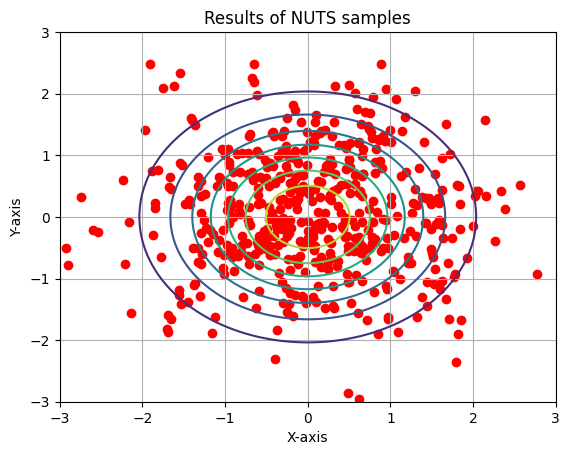

In [81]:
# Define the mean and covariance of the example distribution
mean = torch.tensor([0.0, 0.0])  # Example for a bivariate normal distribution
covariance = torch.tensor([[1.0, 0.0], [0.0, 1.0]])
mvn = MultivariateNormal(mean, covariance_matrix=covariance)

# Plot the contour of the pdf of example distribution
x, y = torch.meshgrid(torch.linspace(-3, 3, 100), torch.linspace(-3, 3, 100))
pos = torch.stack((x.flatten(), y.flatten()), dim=-1)
log_pdf_values = mvn.log_prob(pos).reshape(100, 100)
pdf_values = torch.exp(log_pdf_values).detach().numpy()
plt.contour(x, y, pdf_values)

# Prepare the pdf of the example distribution for NUTS simulation
def multivariate_pdf(x):
    mean = torch.tensor([0.0, 0.0])
    covariance = torch.tensor([[1.0, 0.0], [0.0, 1.0]])
    mvn = MultivariateNormal(mean, covariance)
    log_pdf_values = mvn.log_prob(x)
    pdf_values = torch.exp(log_pdf_values)
    return pdf_values

# Run the NUTS simulation and get the samples
nuts = NUTS(multivariate_pdf, [2.0, 2.0], 0.01, 500)
sample_coordinates = nuts.simulate()

# Overlay the samples to the contour as scatter points
for point in sample_coordinates:
    point = point.detach().numpy()
    plt.scatter(point[0], point[1], color='red')

plt.title('Results of NUTS samples')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid(True)
plt.show()


From this plot, we can see that the distribution is quite different from the one plotted by HMC. Distribution of points on this plot is more diverse and randomly distributed. In order to compare the performance, we can sample the original distribution and compare which distribution is more similar to the original one.

# Discussion

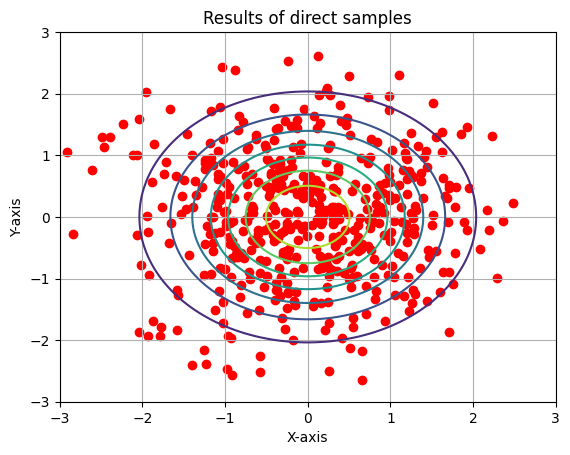

In [86]:
# Plot the samples directly drawn from the original distribution

mean = torch.tensor([0.0, 0.0])
covariance = torch.tensor([[1.0, 0.0], [0.0, 1.0]])
mvn = MultivariateNormal(mean, covariance_matrix=covariance)
x, y = torch.meshgrid(torch.linspace(-3, 3, 100), torch.linspace(-3, 3, 100))
pos = torch.stack((x.flatten(), y.flatten()), dim=-1)
log_pdf_values = mvn.log_prob(pos).reshape(100, 100)
pdf_values = torch.exp(log_pdf_values).detach().numpy()
plt.contour(x, y, pdf_values)
for i in range(500):
    sample = mvn.sample().detach().numpy()
    point_x = sample[0]
    point_y = sample[1]
    plt.scatter(point_x, point_y, color='red')
plt.title('Results of direct samples')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.grid(True)
plt.show()

From this figure, we can see that the distribution is very similar to the NUTS's one, which means that the NUTS has a better performance than the traditional HMC algorithm. One of the possible reason is that the fixed L always stop the simulation when the particle is moving backward, which will make the sampled results stay closer to the origin. Therefore, it is definitely worth using NUTS to replace the traditional HMC algorithm.